In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Coordinates for main cities of each region in Uzbekistan
coordinates = {
    'Andijan': (40.7821, 72.3442),
    'Bukhara': (39.7747, 64.4286),
    'Fergana': (40.3864, 71.7843),
    'Jizzakh': (40.1250, 67.8803),
    'Kashkadarya': (38.8610, 65.7847),
    'Khorezm': (41.5503, 60.6417),
    'Namangan': (40.9983, 71.6726),
    'Navoi': (40.0844, 65.3792),
    'Samarkand': (39.6542, 66.9597),
    'Surkhandarya': (37.2245, 67.2783),
    'Syrdarya': (40.4958, 68.7845),
    'Tashkent R': (41.3111, 69.2797),
    'Tashkent C': (41.3111, 69.2797),
    'Karakalpakstan': (42.4531, 59.6100)
}

In [3]:
# Placeholder mapping for regions
region_names = list(coordinates.keys())
region_placeholders = [f'R{i + 1}' for i in range(len(region_names))]
region_mapping = dict(zip(region_placeholders, region_names))

In [4]:
# Load CSV datasets
file_paths = ['Brucellosis.csv', 'Dysentery.csv', 'Measles.csv', 'Tuberc.csv',
              'Scarlet_fever.csv', 'Typhoid_fever.csv', 'Meningococcal_inf.csv']

In [5]:
# Weights for each dataset
# weights = [2.0, 9.0, 0.5, 3.0, 2.0, 3.0, 0.2]
weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Coordinate weight
use_coords = False
coord_weight = 2.0

In [6]:
# Load and preprocess datasets
def load_and_preprocess(file_paths, years, weights, use_coords, coord_weight):
    scaler = StandardScaler()
    aggregated_data = None

    for i, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path)
        print(f"Processing file: {file_path}")

        # Ensure year columns are strings
        df.columns = df.columns.astype(str)

        # Check if all year columns exist in the DataFrame
        missing_years = [year for year in years if year not in df.columns]
        if missing_years:
            print(f"Missing columns in {file_path}: {missing_years}")
            continue

        # Filter relevant columns and set 'Territories' as the index
        df_filtered = df[['Territories'] + years].set_index('Territories')
        print(f"Initial df_filtered shape: {df_filtered.shape}")

        # Replace '-' with NaN and convert to numeric
        df_filtered.replace('-', np.nan, inplace=True)
        df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

        # Drop rows with all NaN values
        df_filtered.dropna(how='all', inplace=True)
        print(f"df_filtered shape after dropping rows with all NaN: {df_filtered.shape}")

        # Ensure all columns are numeric and drop any non-numeric columns
        df_filtered = df_filtered.select_dtypes(include=[np.number])

        # Fill remaining NaN values with column means
        df_filtered.fillna(df_filtered.mean(axis=0), inplace=True)
        print(f"df_filtered after filling NaNs:\n{df_filtered}")

        # Skip processing if there are no valid rows left
        if df_filtered.shape[0] == 0:
            print(f"No valid data in {file_path} after preprocessing. Skipping this file.")
            continue

        # Scale the data
        df_scaled = scaler.fit_transform(df_filtered)
        df_mean = df_scaled.mean(axis=1) * weights[i]

        # Aggregate the data
        if aggregated_data is None:
            aggregated_data = pd.DataFrame(df_mean, columns=[file_path])
        else:
            aggregated_data[file_path] = df_mean

    # Add coordinates
    if aggregated_data is not None:
        aggregated_data['Latitude'] = [coordinates[region_mapping[ph]][0] for ph in region_placeholders[:len(aggregated_data)]]
        aggregated_data['Longitude'] = [coordinates[region_mapping[ph]][1] for ph in region_placeholders[:len(aggregated_data)]]

        aggregated_data['Placeholder'] = region_placeholders[:len(aggregated_data)]
        aggregated_data.set_index('Placeholder', inplace=True)

        # Normalize coordinates if use_coords is True
        if use_coords:
            coords_scaled = scaler.fit_transform(aggregated_data[['Latitude', 'Longitude']])
            aggregated_data['Latitude_scaled'] = coords_scaled[:, 0] * coord_weight
            aggregated_data['Longitude_scaled'] = coords_scaled[:, 1] * coord_weight

        # Calculate the average including coordinates if applicable
        if use_coords:
            aggregated_data['Average'] = aggregated_data.mean(axis=1)
            data_for_clustering = aggregated_data[['Average', 'Latitude_scaled', 'Longitude_scaled']]
        else:
            aggregated_data['Average'] = aggregated_data.mean(axis=1)
            data_for_clustering = aggregated_data[['Average']]
    else:
        print("No valid data found in any file. Exiting.")
        return None, None

    return aggregated_data, data_for_clustering

In [7]:
# Load data
years = [str(year) for year in range(2010, 2020)]
aggregated_data, data_for_clustering = load_and_preprocess(file_paths, years, weights, use_coords, coord_weight)

# Ensure all values in the DataFrame are numeric
data_for_clustering = data_for_clustering.apply(pd.to_numeric, errors='coerce')

# Replace NaNs and infinite values with zeros
data_for_clustering.replace([np.inf, -np.inf], 0, inplace=True)
data_for_clustering.fillna(0, inplace=True)

# Perform hierarchical clustering
linked = linkage(data_for_clustering, method='ward')

Processing file: Brucellosis.csv
Initial df_filtered shape: (14, 10)
df_filtered shape after dropping rows with all NaN: (14, 10)
df_filtered after filling NaNs:
                2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
Territories                                                               
Karakalpakstan   0.2   0.3   0.1   0.1   0.0   0.2   0.2   0.3   0.0   0.2
Andijan          0.7   0.7   0.7   0.7   0.2   0.2   0.2   0.3   0.2   0.3
Bukhara          6.3   4.8   5.4   4.1   6.0   3.0   4.0   5.6   4.5   3.8
Jizzakh          7.3   6.5   7.1   8.0   9.9   9.9   8.5   8.1   7.1   7.0
Kashkadarya      3.0   3.0   2.1   2.0   3.1   3.8   4.5   4.4   3.7   5.5
Navoi            3.2   7.0   4.9   2.9  13.8  10.6  11.4   8.2   7.9   3.6
Namangan         0.1   0.1   0.1   0.2   0.0   0.0   0.0   0.3   1.0   0.4
Samarkand        1.4   1.3   0.6   1.1   1.4   1.7   1.5   2.4   2.5   2.4
Surkhandarya     0.8   0.7   0.8   9.6   6.0  12.6  10.8   9.7   8.9   5.3
Syrdarya     

/Users/ayau/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/ayau/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/ayau/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
# Binary Tree Node class
class TreeNode:
    def __init__(self, name, left=None, right=None):
        self.name = name
        self.left = left
        self.right = right

# Build binary tree from linkage matrix
def build_binary_tree(linkage_matrix, labels):
    nodes = [TreeNode(name=label) for label in labels]
    for i, (idx1, idx2, _, _) in enumerate(linkage_matrix):
        node1 = nodes[int(idx1)]
        node2 = nodes[int(idx2)]
        new_node = TreeNode(name=f"Cluster {i + 1}", left=node1, right=node2)
        nodes.append(new_node)
    return nodes[-1]

In [9]:
def visualize_binary_tree(node, title, region_mapping):
    G, pos, labels, depths = nx.DiGraph(), {}, {}, {}

    # Recursively add nodes and edges with dynamic spacing
    def add_edges_and_labels(graph, root, pos, labels, depths, depth=0, x=0, y=0, width=5.0, height=1.5):
        graph.add_node(root.name)
        pos[root.name] = (x, y)
        labels[root.name] = root.name
        depths[root.name] = depth

        # Increase spacing based on depth
        next_width = width / 2.0
        next_height = height

        if root.left:
            graph.add_edge(root.name, root.left.name)
            add_edges_and_labels(graph, root.left, pos, labels, depths, depth + 1, x - next_width, y - next_height, next_width, next_height)
        if root.right:
            graph.add_edge(root.name, root.right.name)
            add_edges_and_labels(graph, root.right, pos, labels, depths, depth + 1, x + next_width, y - next_height, next_width, next_height)

    add_edges_and_labels(G, node, pos, labels, depths)

    # Assign pastel colors to nodes based on depth
    node_colors = [plt.cm.Pastel1(depth % 8) for depth in depths.values()]

    # Draw the graph
    fig, ax = plt.subplots(figsize=(14, 10))  # Increase figure size
    nx.draw(G, pos, with_labels=True, node_size=800, node_color=node_colors, font_size=9, font_weight="bold",
            edgecolors="black", ax=ax)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)

    # Add a legend for the regions
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Pastel1(i % 8), markersize=10)
                      for i in range(len(region_mapping))]
    legend_labels = [f"{ph} - {region}" for ph, region in region_mapping.items()]
    ax.legend(legend_handles, legend_labels, title='Region Legend', loc='upper left', bbox_to_anchor=(1.05, 1))

    # Add margins to avoid cutoff
    ax.margins(0.1)

    plt.title(title)
    plt.show()

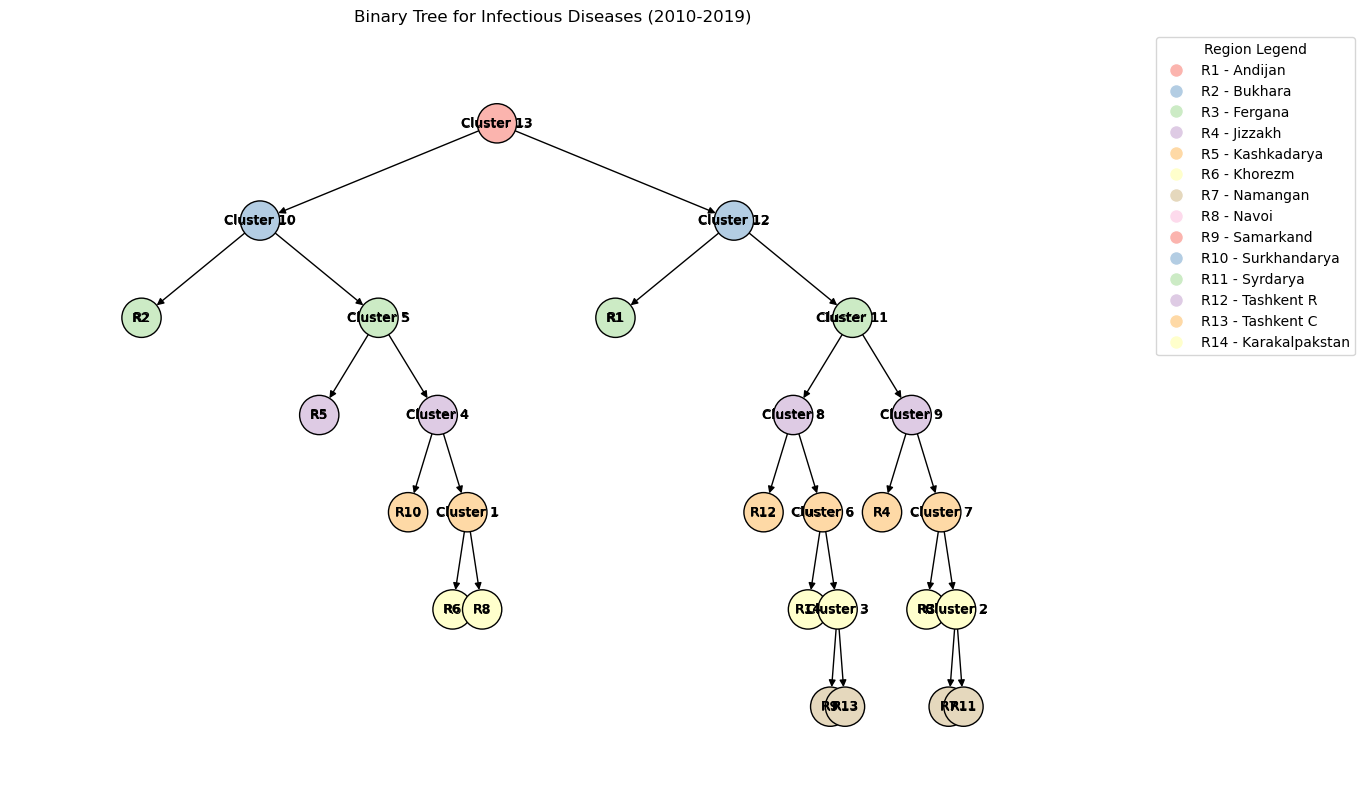

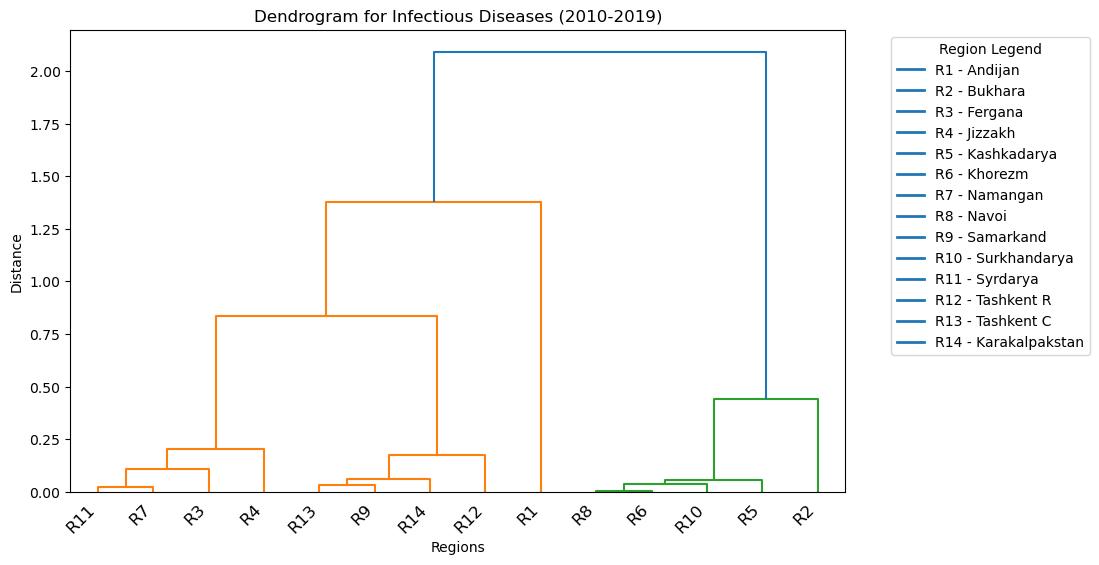

In [10]:
# Build and visualize the binary tree
binary_tree = build_binary_tree(linked, aggregated_data.index.tolist())
visualize_binary_tree(binary_tree, "Binary Tree for Infectious Diseases (2010-2019)", region_mapping)

# Create dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    linked,
    orientation='top',
    labels=aggregated_data.index.tolist(),
    distance_sort='descending'
)
plt.title('Dendrogram for Infectious Diseases (2010-2019)')
plt.xlabel('Regions')
plt.ylabel('Distance')

plt.xticks(rotation=45, ha='right')

# Add legend dynamically for all regions
handles = [plt.Line2D([0], [0], color='tab:blue', lw=2) for _ in aggregated_data.index]
labels = [f"{ph} - {region_mapping[ph]}" for ph in aggregated_data.index]
plt.legend(handles, labels, title='Region Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()